## Sujet 6 : Autour du Paradoxe de Simpson

**Objectifs :**

* Représentez dans un tableau le nombre total de femmes vivantes et décédées sur la période en fonction de leur habitude de tabagisme. Calculez dans chaque groupe (fumeuses / non fumeuses) le taux de mortalité (le rapport entre le nombre de femmes décédées dans un groupe et le nombre total de femmes dans ce groupe). Vous pourrez proposer une représentation graphique de ces données et calculer des intervalles de confiance si vous le souhaitez. En quoi ce résultat est-il surprenant ? <br><br>

* Reprenez la question 1 (effectifs et taux de mortalité) en rajoutant une nouvelle catégorie liée à la classe d'âge. On considérera par exemple les classes suivantes : 18-34 ans, 34-54 ans, 55-64 ans, plus de 65 ans. En quoi ce résultat est-il surprenant ? Arrivez-vous à expliquer ce paradoxe ? De même, vous pourrez proposer une représentation graphique de ces données pour étayer vos explications. <br><br>

* Afin d'éviter un biais induit par des regroupements en tranches d'âges arbitraires et non régulières, il est envisageable d'essayer de réaliser une régression logistique. Si on introduit une variable Death valant 1 ou 0 pour indiquer si l'individu est décédé durant la période de 20 ans, on peut étudier le modèle Death ~ Age pour étudier la probabilité de décès en fonction de l'âge selon que l'on considère le groupe des fumeuses ou des non fumeuses. Ces régressions vous permettent-elles de conclure sur la nocivité du tabagisme ? Vous pourrez proposer une représentation graphique de ces régressions (en n'omettant pas les régions de confiance).


## Lecture des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import seaborn as sea

In [2]:
data = pd.read_csv('Paradox_Simpson.csv')
data.head()

,Smoker,Status,Age
0,Yes,Alive,21.0
1,Yes,Alive,19.3
2,No,Dead,57.5
3,No,Alive,47.1
4,Yes,Alive,81.4


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Smoker  1314 non-null   object 
 1   Status  1314 non-null   object 
 2   Age     1314 non-null   float64
dtypes: float64(1), object(2)
memory usage: 30.9+ KB


On a un dataframe de 3 colonnes et 1314 lignes. Il contient les données sur 1314 femmes qu'on repertorie ici selon trois critères :

* Colonne `Smoker` : Est-elle fumeuse? Yes/No
* Colonne `Status` : Est-elle vivante ou décédée ? Alive/Dead
* Colonne `Age` : Pour indiquer l'âge de la femme

Notons du reste, que le dataframe ne contient **aucune valeur manquante.**

## Analyse : 

Dans un premier temps, le but est de construire un tableau qui recense le nombre total de femmes vivantes et decédées en fonction de leurs habitudes de tabagisme

In [4]:
count = data.groupby(['Smoker', 'Status']).size().reset_index(name="Count")
count

,Smoker,Status,Count
0,No,Alive,502
1,No,Dead,230
2,Yes,Alive,443
3,Yes,Dead,139


On s'interesse alors au taux de mortalité de chaque groupe , c'est-à-dire le rapport entre le nombre de femmes décédées dans un groupe et le nombre total de femmes dans ce groupe

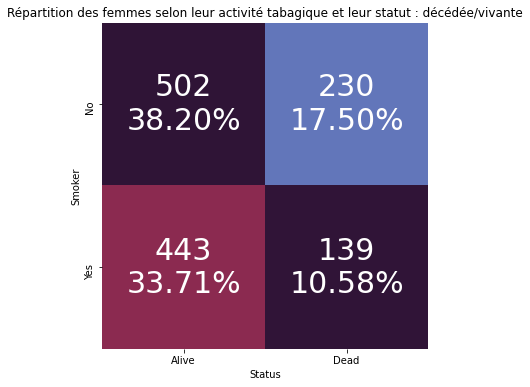

In [5]:
count = np.array(data.groupby(['Smoker', 'Status']).count())
count = np.reshape(count, (2, 2))
annots = np.array([f"{v}\n{v/len(data):.2%}" for v in count.flatten()]).reshape(2,2)

plt.figure(figsize=(10,6))
sea.heatmap(count, annot=annots, fmt="", cmap='twilight_shifted', cbar=False, square=True,
           xticklabels=['Alive', 'Dead'], yticklabels=['No', 'Yes'], annot_kws={"fontsize": 30})
plt.xlabel("Status")
plt.ylabel("Smoker")
plt.title("Répartition des femmes selon leur activité tabagique et leur statut : décédée/vivante")
plt.show()

In [6]:
 z = 1.96

num_smokers = sum(data['Smoker'] == "Yes")
num_dead_smokers = sum(np.logical_and(data['Smoker'] == "Yes", data['Status'] == "Dead"))
rate_smokers = num_dead_smokers / num_smokers
ci_smokers = z * (rate_smokers * (1 - rate_smokers) / num_smokers) ** 0.5
print(f"Mortality rate for smokers:\t{rate_smokers:.2%} " + u"\u00B1" + f" {ci_smokers:.2%}")

num_non_smokers = len(data) - num_smokers
num_dead_non_smokers = sum(np.logical_and(data['Smoker'] == "No", data['Status'] == "Dead"))
rate_non_smokers = num_dead_non_smokers / num_non_smokers
ci_non_smokers = z * (rate_non_smokers * (1 - rate_non_smokers) / num_non_smokers) ** 0.5
print(f"Mortality rate for non smokers:\t{rate_non_smokers:.2%} " + u"\u00B1" + f" {ci_non_smokers:.2%}")

Mortality rate for smokers:	23.88% ± 3.46%
Mortality rate for non smokers:	31.42% ± 3.36%


On constate qu'il y a plus de décès de femmes non fumeuses que de femmes fumeuses, dans l'absolu comme en proportion. Cependant, impossible d'établir un lien de causalité ou une quelconque conclusion à ce stade de l'étude car nous n'avons pas une information importante : l'âge

---

Incluons l'âge sous forme de quatre classes : 18-34 ans, 34-54 ans, 55-64 ans, plus de 65 ans.

In [7]:
#On s'assure qu'on ne va exclure aucune femme de notre analyse
for line in data['Age']:
    bizarre = 0
    if line < 18:
        bizarre +=1
print(bizarre)

0


In [8]:
 def classe_age(age):
    if age < 35:
        return "18-34 ans"
    elif age < 55:
        return "35-54 ans"
    elif age < 65:
        return "55-64 ans"
    else:
        return "+65 ans"

data['Classe'] = data['Age'].apply(classe_age)
data.head()

,Smoker,Status,Age,Classe
0,Yes,Alive,21.0,18-34 ans
1,Yes,Alive,19.3,18-34 ans
2,No,Dead,57.5,55-64 ans
3,No,Alive,47.1,35-54 ans
4,Yes,Alive,81.4,+65 ans


Reprenons maintenant notre première analyse en incluant l'âge cette fois-ci

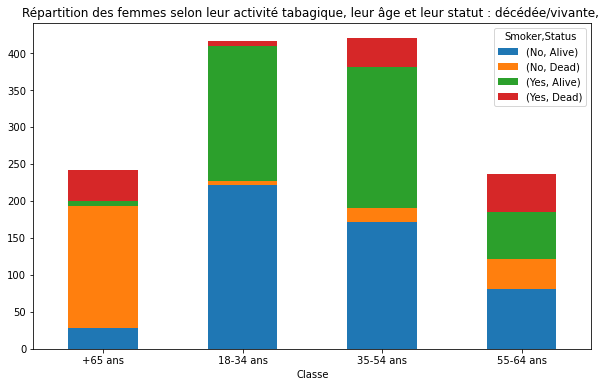

In [9]:
 _, ax = plt.subplots(figsize=(10, 6))
data.pivot_table(index=['Classe'], columns=['Smoker', 'Status'], aggfunc='size').plot(kind='bar', stacked=True, ax=ax)
ax.set_title("Répartition des femmes selon leur activité tabagique, leur âge et leur statut : décédée/vivante, ")
ax.tick_params(axis="x", rotation=0)
plt.show()

En incluant l'âge dans notre analyse, on remarque que la majorité des femmes non fumeuses décédées ont plus de 65 ans. Pour les autres classes d'âges, les résultats sont assez compliqués à interpreter. On calcule alors le taux de mortalité pour chacune de nos classes. 

In [10]:
def ci_per_age(age_group):
    pop = data[data['Classe'] == group]
    print(f"Classe: {group}")
    
    num_smokers = sum(pop['Smoker'] == "Yes")
    num_dead_smokers = sum(np.logical_and(pop['Smoker'] == "Yes", pop['Status'] == "Dead"))
    rate_smokers = num_dead_smokers / num_smokers
    ci_smokers = z * (rate_smokers * (1 - rate_smokers) / num_smokers) ** 0.5
    print(f"\tMortality rate for smokers:\t{rate_smokers:.2%} " + u"\u00B1" + f" {ci_smokers:.2%}")

    num_non_smokers = len(pop) - num_smokers
    num_dead_non_smokers = sum(np.logical_and(pop['Smoker'] == "No", pop['Status'] == "Dead"))
    rate_non_smokers = num_dead_non_smokers / num_non_smokers
    ci_non_smokers = z * (rate_non_smokers * (1 - rate_non_smokers) / num_non_smokers) ** 0.5
    print(f"\tMortality rate for non smokers:\t{rate_non_smokers:.2%} " + u"\u00B1" + f" {ci_non_smokers:.2%}")
    
for group in sorted(data['Classe'].unique()):
    ci_per_age(group)
    print()

Classe: +65 ans
	Mortality rate for smokers:	85.71% ± 9.80%
	Mortality rate for non smokers:	85.49% ± 4.97%

Classe: 18-34 ans
	Mortality rate for smokers:	3.70% ± 2.69%
	Mortality rate for non smokers:	2.64% ± 2.09%

Classe: 35-54 ans
	Mortality rate for smokers:	17.03% ± 4.87%
	Mortality rate for non smokers:	9.95% ± 4.24%

Classe: 55-64 ans
	Mortality rate for smokers:	44.35% ± 9.08%
	Mortality rate for non smokers:	33.06% ± 8.38%



On constate maintenant que le taux de mortalité est bien plus elevé chez les femmes fumeuses que chez les non-fumeuses lorsqu'on s'interesse aux personnes ayant entre 35 et 65 ans. On remarque également que le taux de mortalité augmente lorsque l'âge augmente ce qui paraît assez cohérent. Les résultats obtenus durant la première analyse et ces derniers sont contradictoires. Le paradoxe est obtenu en ajoutant cette classe d'âge qui permet d'obtenir de nouvelles informations sur nos données, comme le fait que la majorité des femmes de plus de 65 ans interrogées sont non-fumeuses. 

## Regression logistique : statsmodel

Afin d'éviter un biais induit par des regroupements en tranches d'âges arbitraires et non régulières, on décide de réaliser une régression logistique. On introduit une variable Death valant 1 ou 0 pour indiquer si l'individu est décédé durant la période de 20 ans. On peut alors étudier le modèle Death ~ Age pour étudier la probabilité de décès en fonction de l'âge selon que l'on considère le groupe des fumeuses ou des non fumeuses

In [11]:
data['Death'] = np.where((data['Status']=="Dead"), 1, 0)
data['Intercept'] = 1
data.head()

,Smoker,Status,Age,Classe,Death,Intercept
0,Yes,Alive,21.0,18-34 ans,0,1
1,Yes,Alive,19.3,18-34 ans,0,1
2,No,Dead,57.5,55-64 ans,1,1
3,No,Alive,47.1,35-54 ans,0,1
4,Yes,Alive,81.4,+65 ans,0,1


On peut maintenant diviser notre dataset en deux selon l'activité tabagique des femmes puis performer notre regression logistique

In [12]:
non_smokers = data[data['Smoker'] == "Yes"]
log_non_smokers = sm.Logit(non_smokers[['Death']],non_smokers[['Intercept','Age']]).fit()
print(log_non_smokers.summary())

Optimization terminated successfully.
         Current function value: 0.412727
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Death   No. Observations:                  582
Model:                          Logit   Df Residuals:                      580
Method:                           MLE   Df Model:                            1
Date:                Sat, 16 Apr 2022   Pseudo R-squ.:                  0.2492
Time:                        18:21:37   Log-Likelihood:                -240.21
converged:                       True   LL-Null:                       -319.94
Covariance Type:            nonrobust   LLR p-value:                 1.477e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5081      0.466    -11.814      0.000      -6.422      -4.594
Age            0.0890      0.

In [13]:
smokers = data[data['Smoker'] == "No"]
log_smokers = sm.Logit(smokers[['Death']], smokers[['Intercept','Age']]).fit()
print(log_non_smokers.summary())

Optimization terminated successfully.
         Current function value: 0.354560
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Death   No. Observations:                  582
Model:                          Logit   Df Residuals:                      580
Method:                           MLE   Df Model:                            1
Date:                Sat, 16 Apr 2022   Pseudo R-squ.:                  0.2492
Time:                        18:21:37   Log-Likelihood:                -240.21
converged:                       True   LL-Null:                       -319.94
Covariance Type:            nonrobust   LLR p-value:                 1.477e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5081      0.466    -11.814      0.000      -6.422      -4.594
Age            0.0890      0.

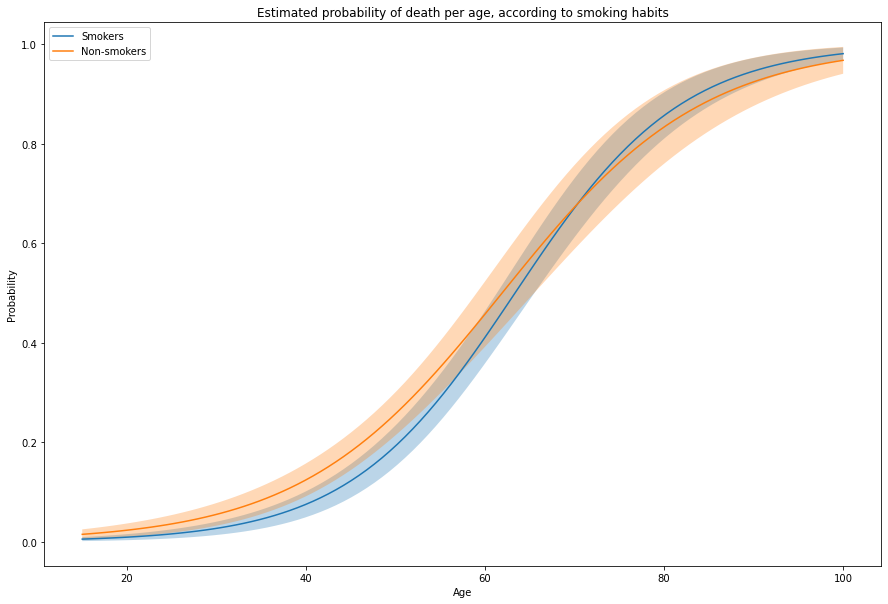

In [14]:
 def plot_pred_confidence_intervals(model, X, xlabel, label=None):
    #https://stackoverflow.com/questions/47414842/confidence-interval-of-probability-prediction-from-logistic-regression-statsmode
    preds = model.predict(X)
    
    cov = model.cov_params()
    gradient = np.array((preds * (1 - preds) * X.T).T)
    std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
    upper = np.maximum(0, np.minimum(1, preds + std_errors * z))
    lower = np.maximum(0, np.minimum(1, preds - std_errors * z))
    
    plt.plot(X[xlabel], preds, label=label)
    plt.fill_between(X[xlabel], lower, upper, alpha=0.3)
    

plt.figure(figsize=(15, 10))
data_pred = pd.DataFrame({'Age': np.linspace(start=15, stop=100, num=100), 'Intercept': 1})

plot_pred_confidence_intervals(log_smokers, data_pred[['Intercept', 'Age']], 'Age', label="Smokers")
plot_pred_confidence_intervals(log_non_smokers, data_pred[['Intercept', 'Age']], 'Age', label="Non-smokers")

plt.title("Estimated probability of death per age, according to smoking habits")
plt.xlabel("Age")
plt.ylabel("Probability")
plt.legend()
plt.show()

À partir du graphique précédent, nous pouvons conclure avec une bonne confiance que la probabilité de décès est plus faible pour les non-fumeurs jusqu'à l'âge de 45/50 ans. À partir de ce point, l'intervalle de confiance pour les non-fumeurs devient plus large et les probabilités prédites se croisent autour de l'âge de 70 ans. La probabilité de décès estimée devient plus élevée pour les non-fumeurs, mais les résultats sont difficiles à interpréter et il n'est pas possible de tirer une conclusion claire sur l'impact du tabagisme sur l'espérance de vie.